<a href="https://colab.research.google.com/github/DavideSecoli/NBA_forecast/blob/master/NBA_XGBoost_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import urllib.request
urllib.request.urlretrieve('https://github.com/GR-NBA-data-challenge/NBA-data-template/raw/master/libupdate.py', 'libupdate.py')
import os, datetime, argparse, requests, urllib.parse, sys, re, traceback, json
import libupdate
libupdate.main()
import libsimulation

import pandas as pd
import math, numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import poisson,skellam
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import cv
from xgboost import XGBRegressor
from xgboost import plot_importance


%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Initialize some settings
settings = libsimulation.SimulationSettings()
# This prevents you accidentally loading data beyond this point, and also defines the start of the simulation run period
settings.cutoff = '2019-01-01'

data_loader = libsimulation.NbaDataLoader(settings)

data_loader.getSeasonV2('2019')

#additional data sources 
get_game = data_loader.getGameV2(12481)
get_players = data_loader.getPlayersV2('2011')

In [0]:
# function to retreive data 

def get_multi_season_game_data(data_loader, first_year, last_year):
    data = [pd.DataFrame(data_loader.getSeasonV2(str(season))) for season in range(first_year, last_year + 1)]
    data = pd.concat(data, axis=0)
    data.dropna(axis=0, inplace=True)
    data.dateTime=pd.to_datetime(data.dateTime)
    data.sort_values('dateTime', inplace=True)
    data.reset_index(inplace=True, drop=True)
    return data

In [0]:
# load all data into tot_data 
train_data = get_multi_season_game_data(data_loader, 2015, 2018)
test_data = get_multi_season_game_data(data_loader, 2019, 2020)
tot_data = get_multi_season_game_data(data_loader, 2015, 2020)

In [0]:
# Train data features 

tot_data['home_blocks_perc'] = tot_data['homeBlocks'] / (tot_data['homeBlocks'] + tot_data['awayBlocks'])
tot_data['away_blocks_perc'] = (1 - tot_data['home_blocks_perc'])

tot_data['home_rebounds_perc'] = tot_data['homeRebounds'] / (tot_data['homeRebounds'] + tot_data['awayRebounds'])
tot_data['away_rebounds_perc'] = (1 - tot_data['home_rebounds_perc'])

tot_data['home_steals_perc'] = tot_data['homeSteals'] / (tot_data['homeSteals'] + tot_data['awaySteals'])
tot_data['away_steals_perc'] = (1 - tot_data['home_steals_perc']) 

tot_data['home_assists_perc'] = tot_data['homeAssists'] / (tot_data['homeAssists'] + tot_data['awayAssists'])
tot_data['away_assists_perc'] = (1 - tot_data['home_assists_perc'])

# Delete columns 
tot_data = tot_data.drop(['gameId','dateTime','status','homeScore','awayScore'], axis=1) # consider droppng 'hometeamId'

In [0]:
tot_data.head()

,homeTeam,homeTeamId,awayTeam,awayTeamId,pointsDiff,pointsSum,homeBlocks,homeMinutes,homeRebounds,homeSteals,homeAssists,quarter0home,quarter1home,quarter2home,quarter3home,awayBlocks,awayMinutes,awayRebounds,awaySteals,awayAssists,quarter0away,quarter1away,quarter2away,quarter3away,season,home_blocks_perc,away_blocks_perc,home_rebounds_perc,away_rebounds_perc,home_steals_perc,away_steals_perc,home_assists_perc,away_assists_perc
0,NO,23.0,ORL,5.0,21.0,181.0,17.0,240.0,62.0,10.0,20.0,24.0,24.0,30.0,23.0,9.0,237.0,55.0,5.0,17.0,25.0,16.0,23.0,20.0,2015,0.653846,0.346154,0.529915,0.470085,0.666667,0.333333,0.540541,0.459459
1,SA,24.0,DAL,25.0,1.0,201.0,3.0,240.0,38.0,5.0,23.0,26.0,19.0,31.0,25.0,3.0,240.0,33.0,9.0,17.0,24.0,29.0,20.0,27.0,2015,0.500000,0.500000,0.535211,0.464789,0.357143,0.642857,0.575000,0.425000
2,LAL,27.0,HOU,22.0,-18.0,198.0,3.0,240.0,36.0,7.0,16.0,19.0,26.0,24.0,21.0,3.0,240.0,47.0,7.0,22.0,31.0,31.0,23.0,23.0,2015,0.500000,0.500000,0.433735,0.566265,0.500000,0.500000,0.421053,0.578947
3,CHA,2.0,MIL,15.0,2.0,214.0,9.0,265.0,50.0,8.0,27.0,25.0,21.0,22.0,32.0,10.0,265.0,35.0,9.0,25.0,24.0,33.0,26.0,17.0,2015,0.473684,0.526316,0.588235,0.411765,0.470588,0.529412,0.519231,0.480769
4,IND,13.0,PHI,7.0,12.0,194.0,13.0,240.0,50.0,5.0,22.0,26.0,22.0,30.0,25.0,5.0,240.0,42.0,10.0,17.0,24.0,27.0,22.0,18.0,2015,0.722222,0.277778,0.543478,0.456522,0.333333,0.666667,0.564103,0.435897


**Data** **preprocessing**

In [0]:
# DATA PREROCESSING 

# Define feature column categories by column type
categorical_cols = [col for col in tot_data.columns if tot_data[col].dtype == 'object']
numeric_cols = [col for col in tot_data.columns if tot_data[col].dtype != 'object']

# Remove the target columns from our feature list
numeric_cols.remove('pointsDiff')
numeric_cols.remove('pointsSum')

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='mean'))

])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # ignore set so new categories in validation set won't trigger an error post test set fit
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numerical_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])

In [0]:
# Grab target as y, remove target from X
tot_data = tot_data.copy()
y = tot_data['pointsSum']
y_diff = tot_data['pointsDiff']
X = tot_data.drop(['pointsSum','pointsDiff'], axis=1)

# Split into train, test for sum 
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, random_state = 42)

# Split into train, test for diff
train_X_diff, val_X_diff, train_y_diff, val_y_diff = train_test_split(X, y_diff, train_size=0.8, random_state = 42)

# Fit the preprocessor using the training data for sum 
train_X_cleaned = preprocessor.fit_transform(train_X)

# Fit the preprocessor using the training data for diff 
train_X_cleaned_diff = preprocessor.fit_transform(train_X_diff)

# SUM: Run the validation set (and all future sets) through the transform without fitting again, or else you'll end up with a different pipeline!
val_X_cleaned = preprocessor.transform(val_X)

# DIFF: Run the validation set (and all future sets) through the transform without fitting again, or else you'll end up with a different pipeline!
val_X_cleaned_diff = preprocessor.transform(val_X_diff)

### **Tune** **XGBoost** **parameters**

Train Untuned XGBoost
Before we tune XGBoost, we first need to make sure we can run the algorithm! XGBoost uses a set of parameters to determine how quickly it converges and what shape it takes.

Technical notes about XGBoost that are useful to know before digging into the algorithm:

The xgboost algorithm uses DMatrix input rather than numpy arrays or pandas dataframes. A DMatrix can contain both the training X and y data (the y data is the "label" of a DMatrix).

Different versions of gradient boosting algorithms give different names to the same tuning parameters, which can get confusing. The following names are equivalent in meaning, although different algorithms may use one or the other as the input name:

**eta** = learning_rate

**min_child_weight** = min_child_leaf

**num_estimators** = num_boost_rounds

XGBoost uses the left side terms above, whereas Scikit learn Gradient Boosting uses the right side terms above.

While we'll go into more depth on each of these parameters, let's try to run XGBoost first. We'll start by saving a set of generic values for all of the parameters in a params dictionary, which we can then pass to xgb along with our training and validation data.

Along with our parameters, we need to give XGBoost two pieces of information:

**num_boost_round**, which is the maximum number of iterations we'll
allow the model to compute. We can set this number high (ex. 999) and hope we never actually have to compute that many iterations, thanks to early_stopping_rounds below!

**early_stopping_rounds**, which is the number of rounds (iterations) the algorithm will compute in a row without model improvement. For example, say early_stopping_rounds = 10. After every round, the algorithm checks model performance. If the model performance hasn't improved in 10 rounds, then training stops, even if we haven't gone through all num_boost_round rounds.

In this first XGB run, we'll report both the best MAE and what round that MAE value occured.

In [0]:

# Create an initial parameter list, which we'll tune as we go.
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
    'eval_metric':'mae'
}

# Set num_boost_rounds for future use
NUM_BOOST_ROUNDS=999

# Take our inputs and format them as DMatrices for SUM
dtrain = xgb.DMatrix(train_X_cleaned, label=train_y)
dtest = xgb.DMatrix(val_X_cleaned, label=val_y)

# Take our inputs and format them as DMatrices for DIFF
dtrain_diff = xgb.DMatrix(train_X_cleaned_diff, label=train_y_diff)
dtest_diff = xgb.DMatrix(val_X_cleaned_diff, label=val_y_diff)

# Train XGB model 
xbg_model = xgb.train(
    params,
    #dtrain,
    dtrain_diff,
    num_boost_round=NUM_BOOST_ROUNDS,
    #evals=[(dtest, "Test")],
    evals=[(dtest_diff, "Test")],
    early_stopping_rounds=10
)
  
print("Best MAE: {:.2f}, found at round {}".format(
                 xbg_model.best_score,
                 xbg_model.best_iteration))

[0]	Test-mae:9.60638
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:8.61399
[2]	Test-mae:7.92602
[3]	Test-mae:7.46876
[4]	Test-mae:7.00312
[5]	Test-mae:6.56698
[6]	Test-mae:6.23337
[7]	Test-mae:5.9909
[8]	Test-mae:5.75291
[9]	Test-mae:5.59545
[10]	Test-mae:5.46114
[11]	Test-mae:5.35105
[12]	Test-mae:5.23061
[13]	Test-mae:5.12035
[14]	Test-mae:5.01948
[15]	Test-mae:4.94424
[16]	Test-mae:4.87662
[17]	Test-mae:4.8097
[18]	Test-mae:4.73209
[19]	Test-mae:4.68297
[20]	Test-mae:4.6342
[21]	Test-mae:4.57978
[22]	Test-mae:4.53758
[23]	Test-mae:4.5053
[24]	Test-mae:4.46482
[25]	Test-mae:4.43051
[26]	Test-mae:4.40369
[27]	Test-mae:4.35435
[28]	Test-mae:4.3158
[29]	Test-mae:4.28551
[30]	Test-mae:4.25477
[31]	Test-mae:4.23489
[32]	Test-mae:4.20252
[33]	Test-mae:4.17092
[34]	Test-mae:4.15362
[35]	Test-mae:4.12579
[36]	Test-mae:4.11036
[37]	Test-mae:4.09151
[38]	Test-mae:4.07711
[39]	Test-mae:4.06195
[40]	Test-mae:4.0371
[41]	Test-mae:4.02602
[42]	Test-mae:4.01159
[43]	Test-mae:

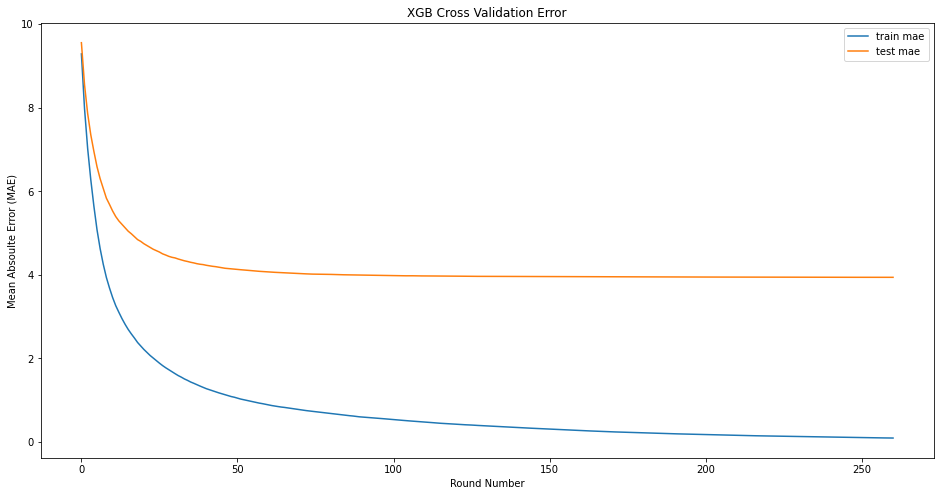

In [0]:
# Calculate cross validation
cv_results = xgb.cv(
    params,
    #dtrain,
    dtrain_diff,
    num_boost_round=NUM_BOOST_ROUNDS,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

# Plot cross validation results
plt.plot(cv_results['train-mae-mean'], label='train mae')
plt.plot(cv_results['test-mae-mean'], label='test mae')
plt.title("XGB Cross Validation Error")
plt.xlabel('Round Number')
plt.ylabel('Mean Absoulte Error (MAE)')
plt.legend()
plt.show()


## **Tuning** **max_depth** **and** **min_child_weight**
First parameters to tune: max_depth and min_child_weight. We'll tune these concurrently using a basic grid search, meaning we'll test all combinations of the two variables in a certain range. Whichever combination has the best cross validation score, we'll pick as our values for the parameters!

What do these two parameters control?

**max_depth** is the largest depth allowed on any decision tree in the ensemble, where tree depth is the number of nodes from the root down to the farthest away leaf. Larger max_depth values allow for more complex trees, which means a larger chance of capturing complicated features but also a larger chance of overfitting.

**min_child_weight** is a regularization factor that changes how often tree nodes split in tree creation. Only nodes with a hessian (second order partial derivative) larger than min_child_weight are allowed to split. Smaller min_child_weight values mean more complex trees, and therefore more chance of overfitting.
As cited in the introduction, this code is partially taken from Hyperparameter tuning in XGBoost.

In [0]:
# Tune max_depth and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,8)
    for min_child_weight in range(1,6)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        #dtrain,
        dtrain_diff,
        num_boost_round=NUM_BOOST_ROUNDS,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=3, min_child_weight=1
	MAE 2.2581966 for 580 rounds

CV with max_depth=3, min_child_weight=2
	MAE 2.2597384 for 657 rounds

CV with max_depth=3, min_child_weight=3
	MAE 2.3126775999999998 for 447 rounds

CV with max_depth=3, min_child_weight=4
	MAE 2.2718046000000003 for 587 rounds

CV with max_depth=3, min_child_weight=5
	MAE 2.2486652 for 671 rounds

CV with max_depth=4, min_child_weight=1
	MAE 2.9133894 for 335 rounds

CV with max_depth=4, min_child_weight=2
	MAE 2.930098 for 450 rounds

CV with max_depth=4, min_child_weight=3
	MAE 2.9152812 for 470 rounds

CV with max_depth=4, min_child_weight=4
	MAE 2.92448 for 357 rounds

CV with max_depth=4, min_child_weight=5
	MAE 2.9133256 for 453 rounds

CV with max_depth=5, min_child_weight=1
	MAE 3.4230194 for 280 rounds

CV with max_depth=5, min_child_weight=2
	MAE 3.4148995999999996 for 267 rounds

CV with max_depth=5, min_child_weight=3
	MAE 3.3951681999999996 for 256 rounds

CV with max_depth=5, min_child_weight=4
	MAE

In [0]:
#SUM MAE: 2.5194491999999995
#params['max_depth'] = 3
#params['min_child_weight'] = 1

#DIFF MAE: 2.2486652
params['max_depth'] = 3
params['min_child_weight'] = 5


## **Tune** **subsample** **and** **colsample**
Great, time to move on to our next two parameters! What do these parameters control?

**subsample** is the fraction of datapoints (rows of the training data) to sample each round (each tree), with 0 meaning no rows are sampled and 1 meaning all rows are sampled. The higher the value, the more likely to overfit the data.

**colsample_bytree** is the fraction of features (columns of the training data) to sample each round (each tree), with 0 meaning no columns are sampled and 1 meaning all columns are sampled. The higher the value, the more likely to overfit the data.

In [0]:
# Next, tune subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        #dtrain,
        dtrain_diff,
        num_boost_round=NUM_BOOST_ROUNDS,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 2.2486652 for 671 rounds

CV with subsample=1.0, colsample=0.9
	MAE 2.2867036 for 730 rounds

CV with subsample=1.0, colsample=0.8
	MAE 2.2745354 for 586 rounds

CV with subsample=1.0, colsample=0.7
	MAE 2.2736341999999996 for 593 rounds

CV with subsample=0.9, colsample=1.0
	MAE 2.295619 for 453 rounds

CV with subsample=0.9, colsample=0.9
	MAE 2.2423208 for 488 rounds

CV with subsample=0.9, colsample=0.8
	MAE 2.2414351999999997 for 570 rounds

CV with subsample=0.9, colsample=0.7
	MAE 2.2845852 for 369 rounds

CV with subsample=0.8, colsample=1.0
	MAE 2.3289788000000002 for 497 rounds

CV with subsample=0.8, colsample=0.9
	MAE 2.3145906 for 394 rounds

CV with subsample=0.8, colsample=0.8
	MAE 2.3433376000000004 for 328 rounds

CV with subsample=0.8, colsample=0.7
	MAE 2.337294 for 397 rounds

CV with subsample=0.7, colsample=1.0
	MAE 2.438047 for 326 rounds

CV with subsample=0.7, colsample=0.9
	MAE 2.3662204 for 376 rounds

CV with subsamp

In [0]:
# SUM MAE: 2.5194491999999995
#params['subsample'] = 1.0
#params['colsample_bytree'] = 1.0 

# DIFF MAE: 2.2414351999999997
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8 

# **Tune** **eta**
Eta in XGBoost works the same way as a learning_rate, in that it controls how quickly each step changes. The smaller the eta, the smaller each step, which means the algorithm will likely take more steps to converge.

In [0]:
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            #dtrain,
            dtrain_diff,
            num_boost_round=NUM_BOOST_ROUNDS,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
	MAE 2.2414351999999997 for 570 rounds

CV with eta=0.2
	MAE 2.0510684 for 818 rounds

CV with eta=0.1
	MAE 1.917233 for 997 rounds

CV with eta=0.05
	MAE 2.1662568 for 998 rounds

CV with eta=0.01
	MAE 4.2836232 for 998 rounds

CV with eta=0.005
	MAE 5.5378913999999995 for 998 rounds

Best params: 0.1, MAE: 1.917233


In [0]:
# SUM MAE: 2.0395146000000004
sum_param = {'colsample_bytree': 1.0,
             'eta': 0.05,
             'eval_metric': 'mae',
             'max_depth': 3,
             'min_child_weight': 1,
             'objective': 'reg:squarederror',
             'subsample': 1.0}
  
# DIFF MAE: 1.917233; 997 rounds 
diff_param = {'colsample_bytree': 0.8,
              'eta': 0.1,
              'eval_metric': 'mae',
              'max_depth': 3,
              'min_child_weight': 5,
              'objective': 'reg:squarederror',
              'subsample': 0.9}


In [0]:
# Put together a final model, using the parameters found in tuning

final_model = xgb.XGBRegressor(n_estimators=986, 
                               learning_rate=0.05, 
                               max_depth = 3, 
                               min_child_weight=1, 
                               subsample=1.0, 
                               colsample_bytree=1.0)

final_model_diff = XGBRegressor(n_estimators=997, 
                                learning_rate=0.1, 
                                max_depth = 3, 
                                min_child_weight=5, 
                                subsample=0.9, 
                                colsample_bytree=0.8)

# Pipeline SUM
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', final_model)])

# Pipeline DIFF
final_pipeline_diff = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', final_model_diff)])

# Preprocessing of validation data, get predictions for SUM 
final_pipeline.fit(train_X,train_y)
test_data_labels = final_pipeline.predict(val_X)
train_data_labels = final_pipeline.predict(train_X)

# Preprocessing of validation data, get predictions for DIFF
final_pipeline_diff.fit(train_X_diff,train_y_diff)
test_data_labels_diff = final_pipeline_diff.predict(val_X_diff)
train_data_labels_diff = final_pipeline_diff.predict(train_X_diff)

# Create predictions to be submitted!
results = pd.DataFrame({'homeTeam': val_X['homeTeam'],'awayTeam': val_X['awayTeam'],
                        'pointsSum': val_y,'predictedPointsSum': test_data_labels,
                        'pointsDiff': val_y_diff, 'predictedPointsDiff': test_data_labels_diff}) 
results

[16:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,homeTeam,awayTeam,pointsSum,predictedPointsSum,pointsDiff,predictedPointsDiff
5360,NY,PHO,238.0,236.738419,-18.0,-17.269978
1086,POR,DEN,234.0,234.135117,6.0,4.409918
5047,DEN,UTA,191.0,190.419434,15.0,15.469049
3617,SA,MEM,184.0,194.466232,6.0,2.102319
2921,HOU,PHO,246.0,242.945694,16.0,16.403168
...,...,...,...,...,...,...
3467,PHO,SAC,208.0,209.619568,-6.0,-4.983862
5247,WAS,BKN,190.0,192.228195,14.0,9.607851
1344,DAL,LAC,226.0,222.833450,10.0,9.791741
5158,CHA,BOS,229.0,230.469910,5.0,3.992653


In [0]:
sum_mean = results['pointsSum'].mean()
diff_mean = results['pointsDiff'].mean()

rmse_train = np.sqrt(mean_squared_error(train_y,train_data_labels))
print("In sample SUM RMSE: %f" % (rmse_train))

rmse_train_diff = np.sqrt(mean_squared_error(train_y_diff,train_data_labels_diff))
print("In sample DIFF RMSE: %f" % (rmse_train_diff))

rmse_test = np.sqrt(mean_squared_error(val_y, test_data_labels))
print("Out of sample SUM RMSE: %f" % (rmse_test))

rmse_test_diff = np.sqrt(mean_squared_error(val_y_diff, test_data_labels_diff))
print("Out of sample DIFF RMSE: %f" % (rmse_test_diff))

train_accuracy = (1 - rmse_train / sum_mean) * 100
test_accuracy = (1 - rmse_test / sum_mean) * 100

print('In sample SUM accuracy is :', train_accuracy)

#In sample SUM RMSE: 3.507907
#In sample DIFF RMSE: 4.407704
#Out of sample SUM RMSE: 4.592524
#Out of sample DIFF RMSE: 5.328730
#In sample SUM accuracy is : 98.31852806530735

In sample SUM RMSE: 1.595290
In sample DIFF RMSE: 0.976098
Out of sample SUM RMSE: 2.699398
Out of sample DIFF RMSE: 2.325618
In sample SUM accuracy is : 99.23531769127149


In [0]:
# Write some code
def predict(required_predictions, data_loader, log=lambda x: print(x)):
    first_year = 2016
    
    log('Loading training data')
    train_data = get_multi_season_game_data(data_loader, first_year=first_year, last_year=2020)
    
    log('Implementing new features on train data')

    # Train data features 

    train_data['home_blocks_perc'] = train_data['homeBlocks'] / (train_data['homeBlocks'] + train_data['awayBlocks'])
    train_data['away_blocks_perc'] = (1 - train_data['home_blocks_perc'])
    train_data['home_rebounds_perc'] = train_data['homeRebounds'] / (train_data['homeRebounds'] + train_data['awayRebounds'])
    train_data['away_rebounds_perc'] = (1 - train_data['home_rebounds_perc'])
    train_data['home_steals_perc'] = train_data['homeSteals'] / (train_data['homeSteals'] + train_data['awaySteals'])
    train_data['away_steals_perc'] = (1 - train_data['home_steals_perc'])
    train_data['home_assists_perc'] = train_data['homeAssists'] / (train_data['homeAssists'] + train_data['awayAssists'])
    train_data['away_assists_perc'] = (1 - train_data['home_assists_perc'])

    # Delete columns 
    train_data = train_data.drop(['gameId','dateTime','status','homeScore','awayScore'], axis=1) # consider droppng 'hometeamId'
    print(train_data.shape)

    # Out of sample data 
    test = train_data[:300]
    # In sample data
    train_data = train_data[300:]

    print(test.shape)

    # DATA PREROCESSING

    # Define feature column categories by column type for train data
    numeric_cols = [col for col in train_data.columns if train_data[col].dtype != 'object']
    categorical_cols = [col for col in train_data.columns if train_data[col].dtype == 'object']


    # Define feature column categories by column type for test data
    numeric_cols_test = [col for col in test.columns if test[col].dtype != 'object']
    categorical_cols_test = [col for col in test.columns if test[col].dtype == 'object']


    # Remove the target columns from our feature list
    numeric_cols.remove('pointsDiff')
    numeric_cols.remove('pointsSum')

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('imputer', SimpleImputer(strategy='mean'))

    ])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # ignore set so new categories in validation set won't trigger an error post test set fit
    ])

    # Bundle preprocessing for numerical and categorical training data
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numerical_transformer, numeric_cols),
            ('categorical', categorical_transformer, categorical_cols)
        ])
    
    # Grab target as y, remove target from X
    train_data = train_data.copy()
    train_y = train_data['pointsSum']
    train_y_diff = train_data['pointsDiff']
    train_X = train_data.drop(['pointsSum','pointsDiff'], axis=1)
    train_X_diff = train_data.drop(['pointsSum','pointsDiff'], axis=1)
    test_y = test['pointsSum']
    test_y_diff = test['pointsDiff']
    test_X = test.drop(['pointsSum','pointsDiff'], axis=1)

    # Fit the preprocessor using the training data X
    #train_X_cleaned = preprocessor.fit_transform(train_X)

    # Fit the preprocessor using the training data for diff 
    #train_X_cleaned_dff = preprocessor.fit_transform(train_X_diff)

    # Run the validation set (and all future sets) through the transform without fitting again, or else you'll end up with a different pipeline!
    #val_X_cleaned = preprocessor.transform(val_X)

    # DIFF: Run the validation set (and all future sets) through the transform without fitting again, or else you'll end up with a different pipeline!
    #val_X_cleaned = preprocessor.transform(val_X_diff)

    log('Fitting XGBoostRegression model')

    # Put together a final model, using the parameters found in tuning

    final_model = XGBRegressor(n_estimators=986, 
                               learning_rate=0.05, 
                               max_depth = 3, 
                               min_child_weight=1, 
                               subsample=1.0, 
                               colsample_bytree=1.0)

    final_model_diff = XGBRegressor(n_estimators=997, 
                                    learning_rate=0.1, 
                                    max_depth = 3, 
                                    min_child_weight=5, 
                                    subsample=0.9, 
                                    colsample_bytree=0.8)

    final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', final_model)])

    final_pipeline_diff = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', final_model_diff)])
    # Fit train for sum  
    final_pipeline_sum = final_pipeline.fit(train_X,train_y)

    # Fit train for diff
    final_pipeline_diff = final_pipeline_diff.fit(train_X_diff,train_y_diff)

    log('Generating predictions')

    test['predictedSum'] = final_pipeline_sum.predict(test_X)
    test['predictedDiff'] = final_pipeline_diff.predict(test_X)
    
    required_predictions['predictedDiff'] = test['predictedDiff']
    required_predictions['predictedSum'] = test['predictedSum']

    results = pd.DataFrame({'homeTeam': test['homeTeam'],'awayTeam': test['awayTeam'],
                            'pointsSum': test_y,'predictedPointsSum': test['predictedSum'],
                            'pointsDiff': test_y_diff, 'predictedPointsDiff': test['predictedDiff']})

    rmse_train = np.sqrt(mean_squared_error(test_y,test['predictedSum']))
    print("Out of sample SUM RMSE: %f" % (rmse_train))

    rmse_train_diff = np.sqrt(mean_squared_error(test_y_diff,test['predictedDiff']))
    print("Out of sample DIFF RMSE: %f" % (rmse_train_diff))
    
    log('Finished')
    
#     return required_predictions.to_dict('records')
    return required_predictions

In [0]:
required_predictions = test_data[:300][['homeTeam', 'awayTeam', 'dateTime', 'gameId']]
required_predictions = predict(required_predictions, data_loader)

Loading training data
Implementing new features on train data
(4238, 33)
(300, 33)
Fitting XGBoostRegression model
[16:47:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Generating predictions
Out of sample SUM RMSE: 2.571294
Out of sample DIFF RMSE: 2.340667
Finished
